## Mean property trends of currents with confidence intervals. Also box plots seperated by CCS region
Summer (may-sep) only to reduce potential sampling bias between programs

In [1]:
# %matplotlib qt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
from scipy.interpolate import UnivariateSpline

import warnings
warnings.filterwarnings("ignore")

OUTPATH = './output'
IOPATH = '/ocean/rbeutel/MOAD/analysis-becca/Synthesis/data/CCS_obs.csv'

## Loading Data and Indicators

In [2]:
obs = pd.read_csv(IOPATH)
for col, count in obs.count().items():
    print(f"{col}: {count} non-NaN values")

Unnamed: 0.1: 1346903 non-NaN values
Unnamed: 0: 1346903 non-NaN values
time: 1346903 non-NaN values
longitude (degrees_east): 1346903 non-NaN values
latitude (degrees_north): 1346903 non-NaN values
depth (m): 1346903 non-NaN values
pressure (dbar): 1346903 non-NaN values
temperature (degC): 1128819 non-NaN values
salinity (g kg-1): 1346903 non-NaN values
density (kg m-3): 1128819 non-NaN values
spice: 1128819 non-NaN values
sigma0 (kg m-3): 1128819 non-NaN values
DO (umol kg-1): 971502 non-NaN values
NO3 (uM): 349700 non-NaN values
NO2 (uM): 299855 non-NaN values
NH4 (uM): 5179 non-NaN values
Nstar (umol kg-1): 342382 non-NaN values
PO4 (uM): 351393 non-NaN values
SiO4 (uM): 53939 non-NaN values
Chl (mg m-3): 35093 non-NaN values
TA (uM): 8214 non-NaN values
DIC (uM): 8201 non-NaN values
Carbonate: 2359 non-NaN values
Aragonite: 7076 non-NaN values
Calcite: 7076 non-NaN values
Cd (nmol kg-1): 229 non-NaN values
Co (nmol kg-1): 225 non-NaN values
Cu (nmol kg-1): 364 non-NaN values
Fe (

In [3]:
obs

,Unnamed: 0.1,Unnamed: 0,time,longitude (degrees_east),latitude (degrees_north),depth (m),pressure (dbar),temperature (degC),salinity (g kg-1),density (kg m-3),...,Ni (nmol kg-1),Zn (nmol kg-1),source,current,location,[TA-DIC] (uM),year,month,NSdist,EWdist
0,0,0,1933-07-25 00:00:00+00:00,-126.76,49.34,1.0,1.008587,NaN,32.070847,NaN,...,NaN,NaN,ios bottle,shelf,shelf,NaN,1933,7,0.000000,-0.0
1,1,1,1933-07-25 00:00:00+00:00,-126.76,49.34,2.0,2.017180,NaN,32.090943,NaN,...,NaN,NaN,ios bottle,shelf,shelf,NaN,1933,7,0.000000,-0.0
2,2,2,1933-07-25 00:00:00+00:00,-126.76,49.34,4.0,4.034378,NaN,32.090906,NaN,...,NaN,NaN,ios bottle,shelf,shelf,NaN,1933,7,0.000000,-0.0
3,3,3,1933-07-25 00:00:00+00:00,-126.76,49.34,6.0,6.051598,NaN,32.090870,NaN,...,NaN,NaN,ios bottle,shelf,shelf,NaN,1933,7,0.000000,-0.0
4,4,4,1933-07-25 00:00:00+00:00,-126.76,49.34,10.0,10.086095,NaN,32.181305,NaN,...,NaN,NaN,ios bottle,shelf,shelf,NaN,1933,7,0.000000,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1346898,1346898,1402109,2024-11-18 00:00:00+00:00,-124.95,44.38,0.0,0.000000,12.713836,32.386146,1024.310554,...,NaN,NaN,ooi,NaN,slope,NaN,2024,11,484.541716,NaN
1346899,1346899,1402110,2024-11-18 00:00:00+00:00,-124.94,44.36,0.0,0.000000,12.712860,32.386131,1024.310730,...,NaN,NaN,ooi,NaN,slope,NaN,2024,11,484.541716,NaN
1346900,1346900,1402111,2024-11-18 00:00:00+00:00,-124.57,46.99,0.0,0.000000,10.586080,32.728763,1024.962773,...,NaN,NaN,ooi,shelf,shelf,NaN,2024,11,215.824564,-0.0
1346901,1346901,1402112,2024-11-18 00:00:00+00:00,-124.56,46.99,0.0,0.000000,12.215222,32.245641,1024.296804,...,NaN,NaN,ooi,shelf,shelf,NaN,2024,11,215.824564,-0.0


In [ ]:
# reduce potential bias caused by sampling programs going out in different months
# summer only (april-sep inclusive) based on PreliminaryCurrentAnalysis.ipynb
obs = obs[(obs.month>=4)&(obs.month<=9)]
obs

,Unnamed: 0.1,Unnamed: 0,time,longitude (degrees_east),latitude (degrees_north),depth (m),pressure (dbar),temperature (degC),salinity (g kg-1),density (kg m-3),...,Ni (nmol kg-1),Zn (nmol kg-1),source,current,location,[TA-DIC] (uM),year,month,NSdist,EWdist
0,0,0,1933-07-25 00:00:00+00:00,-126.76,49.34,1.0,1.008587,NaN,32.070847,NaN,...,NaN,NaN,ios bottle,shelf,shelf,NaN,1933,7,0.000000,-0.0
1,1,1,1933-07-25 00:00:00+00:00,-126.76,49.34,2.0,2.017180,NaN,32.090943,NaN,...,NaN,NaN,ios bottle,shelf,shelf,NaN,1933,7,0.000000,-0.0
2,2,2,1933-07-25 00:00:00+00:00,-126.76,49.34,4.0,4.034378,NaN,32.090906,NaN,...,NaN,NaN,ios bottle,shelf,shelf,NaN,1933,7,0.000000,-0.0
3,3,3,1933-07-25 00:00:00+00:00,-126.76,49.34,6.0,6.051598,NaN,32.090870,NaN,...,NaN,NaN,ios bottle,shelf,shelf,NaN,1933,7,0.000000,-0.0
4,4,4,1933-07-25 00:00:00+00:00,-126.76,49.34,10.0,10.086095,NaN,32.181305,NaN,...,NaN,NaN,ios bottle,shelf,shelf,NaN,1933,7,0.000000,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1346330,1346330,1401508,2024-09-30 00:00:00+00:00,-124.57,46.99,0.0,0.000000,10.000050,33.328536,1025.527358,...,NaN,NaN,ooi,shelf,shelf,NaN,2024,9,215.824564,-0.0
1346331,1346331,1401509,2024-09-30 00:00:00+00:00,-124.56,46.99,0.0,0.000000,12.388119,32.661681,1024.585241,...,NaN,NaN,ooi,shelf,shelf,NaN,2024,9,215.824564,-0.0
1346332,1346332,1401510,2024-09-30 00:00:00+00:00,-124.31,44.64,0.0,0.000000,9.441516,33.522238,1025.769626,...,NaN,NaN,ooi,shelf,shelf,NaN,2024,9,446.476618,NaN
1346333,1346333,1401511,2024-09-30 00:00:00+00:00,-124.27,47.13,0.0,0.000000,11.669242,32.555657,1024.637082,...,NaN,NaN,ooi,shelf,shelf,NaN,2024,9,215.824564,-0.0


In [5]:
# Setting up different currents
obs_shelf = obs[obs['current'] == 'shelf']
obs_cuc = obs[obs['current'] == 'CUC']
obs_cc = obs[obs['current'] == 'CC']

# make a 'dist' column of the distances we're actually going to use for each current
# for shelf and cuc its simply the NS dist

obs_cuc['dist'] = obs_cuc.NSdist
obs_shelf['dist'] = obs_shelf.NSdist

# for the CC its a bit more complicated
# first, just pick whatever line the point is closer to
abs_a = obs_cc.NSdist.abs()
abs_b = obs_cc.EWdist.abs()

obs_cc['dist'] = np.select(
    [
        abs_a < abs_b,       # a closer to zero
        abs_b < abs_a,       # b closer to zero
        abs_a.isna(),        # a NaN, take b
        abs_b.isna()         # b NaN, take a
    ],
    [
        obs_cc.NSdist,
        obs_cc.EWdist,
        obs_cc.EWdist,
        obs_cc.NSdist
    ],
    default=np.nan
)

# and then also default that anywhere that the NS dist is -ve, the EW distance should be taken
obs_cc.dist[obs_cc.NSdist < 0] = obs_cc.EWdist

## Figures

In [6]:
def plot_property_NStrend(d_out, var_string, current_string, subplot_pos):
    if current_string == 'CUC':
        obs_used = obs_cuc
    elif current_string == 'shelf':
        obs_used = obs_shelf
    elif current_string == 'CC':
        obs_used = obs_cc
    else:
        raise ValueError("Invalid current_string. Use 'CC', 'CUC', or 'shelf'.")

    ylim_dict = {'spice': [-2, 3], 'temperature (degC)': [5, 20], 'salinity (g kg-1)': [30, 35],
                 'DO (umol kg-1)': [0,400], 'NO3 (uM)': [0,50], '[TA-DIC] (uM)': [-50,300]}

    x = np.asarray(d_out)
    y = np.asarray(obs_used[var_string])
    m = np.isfinite(x) & np.isfinite(y)
    if m.sum() < 5:
        raise ValueError("Not enough finite data to fit a trend.")

    # --- bin distances (vectorized) ---
    base = 200.0
    x_bin = np.round(x[m] / base) * base

    df = pd.DataFrame({'x_bin': x_bin, 'y': y[m]})
    g = df.groupby('x_bin', sort=True)

    xu   = g['y'].mean().index.values
    ybar = g['y'].mean().values
    s    = g['y'].std(ddof=1).values
    n    = g.size().values

    # --- drop small-n bins ---
    keep = n >= 3
    xu, ybar, s, n = xu[keep], ybar[keep], s[keep], n[keep]
    if xu.size < 5:
        raise ValueError("Too few bins with n≥3 to fit a smooth trend.")

    # --- standard error and t-crit ---
    se = s / np.sqrt(n)
    dfree = np.maximum(n - 1, 1)  # avoid 0
    tcrit = stats.t.ppf(0.975, df=dfree)

    # --- smoothing: weighted spline on mean; separate smooth on log(se) ---
    # weights = 1/se (clip to avoid infinities)
    se_clip = np.clip(se, np.nanmax(se)*1e-6, np.nanmax(se)*1e6)
    w = 1.0 / se_clip

    # --- cap leverage of dominant bins so we don't get crazy jumps just bc there's a lot of data
    max_ratio = 10.0  # max allowed ratio of (weight / median weight)
    med_w = np.median(w)
    w = np.minimum(w, med_w * max_ratio)
    w /= med_w  # normalize so median weight ~ 1
    # ===========================================

    # Choose s proportional to variance * number of points (rule of thumb)
    s_mean = np.nanvar(ybar) * xu.size

    mean_spline = UnivariateSpline(xu, ybar, w=w, s=s_mean)

    # Smooth log(SE) to keep positivity and avoid negative wiggles
    se_pos = np.clip(se, np.finfo(float).eps, None)
    logse_spline = UnivariateSpline(xu, np.log(se_pos), s=xu.size * 0.5)

    # Evaluate on a fine grid
    x_fine = np.linspace(xu.min(), xu.max(), 600)
    y_smooth = mean_spline(x_fine)
    se_smooth = np.exp(logse_spline(x_fine))

    # tcrit varies slowly with n; use median df for evaluation (or spline tcrit too)
    tcrit_med = stats.t.ppf(0.975, df=int(np.median(dfree)))
    lower = y_smooth - tcrit_med * se_smooth
    upper = y_smooth + tcrit_med * se_smooth

    # --- plot ---
    ax[subplot_pos].scatter(x[m], y[m], s=2, alpha=0.2, c='k', linewidths=0)
    ax[subplot_pos].plot(x_fine, y_smooth, label='Trend (weighted spline)', color='blue')
    ax[subplot_pos].fill_between(x_fine, lower, upper, color='blue', alpha=0.25, label='95% CI (approx)')

    if var_string in ylim_dict:
        ax[subplot_pos].set_ylim(ylim_dict[var_string])

    ax[subplot_pos].set_xlim([np.nanmin(x) - 100, np.nanmax(x) + 100])
    ax[subplot_pos].set_xlabel('Distance Along Line (km)')
    ax[subplot_pos].set_ylabel('Spice (kg m-3)' if var_string == 'spice' else var_string)
    ax[subplot_pos].set_title(f'{var_string} trend down {current_string}')
    # ax[subplot_pos].grid(True)
    # ax[subplot_pos].legend()

    # add lines for JdF, Cape Mendocino, and Point Conception
    ax[subplot_pos].plot([0,0],[-1000,1000],'k--',alpha=0.5) # JdF
    ax[subplot_pos].plot([900,900],[-1000,1000],'k--',alpha=0.5) # Cape Mendocino
    ax[subplot_pos].plot([1675,1675],[-1000,1000],'k--',alpha=0.5) # Point Conception
    if current_string == 'CUC':
        ax[subplot_pos].text(0.17,0.98,'JdF',ha='right',va='top',transform=ax[subplot_pos].transAxes,fontsize=10)
        ax[subplot_pos].text(0.46,0.98,'CM',ha='right',va='top',transform=ax[subplot_pos].transAxes,fontsize=10)
        ax[subplot_pos].text(0.71,0.98,'PC',ha='right',va='top',transform=ax[subplot_pos].transAxes,fontsize=10)
    else:
        ax[subplot_pos].text(0.31,0.98,'JdF',ha='right',va='top',transform=ax[subplot_pos].transAxes,fontsize=10)
        ax[subplot_pos].text(0.55,0.98,'CM',ha='right',va='top',transform=ax[subplot_pos].transAxes,fontsize=10)
        ax[subplot_pos].text(0.76,0.98,'PC',ha='right',va='top',transform=ax[subplot_pos].transAxes,fontsize=10)

    # return xu, ybar


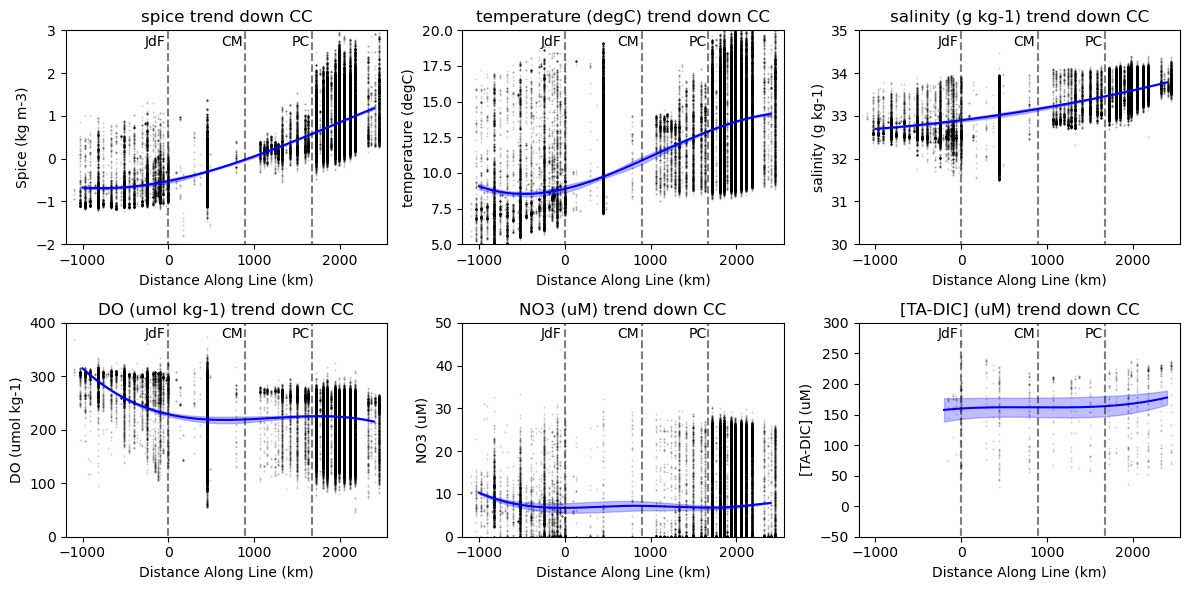

In [ ]:
x = obs_cc['dist']
current = 'CC'
fig, ax = plt.subplots(2,3, figsize=(12, 6))

plot_property_NStrend(x, 'spice', current, (0,0))
plot_property_NStrend(x, 'temperature (degC)', current, (0,1))
plot_property_NStrend(x, 'salinity (g kg-1)', current, (0,2))
plot_property_NStrend(x, 'DO (umol kg-1)', current, (1,0))
plot_property_NStrend(x, 'NO3 (uM)', current, (1,1))
plot_property_NStrend(x, '[TA-DIC] (uM)', current, (1,2))

plt.tight_layout()

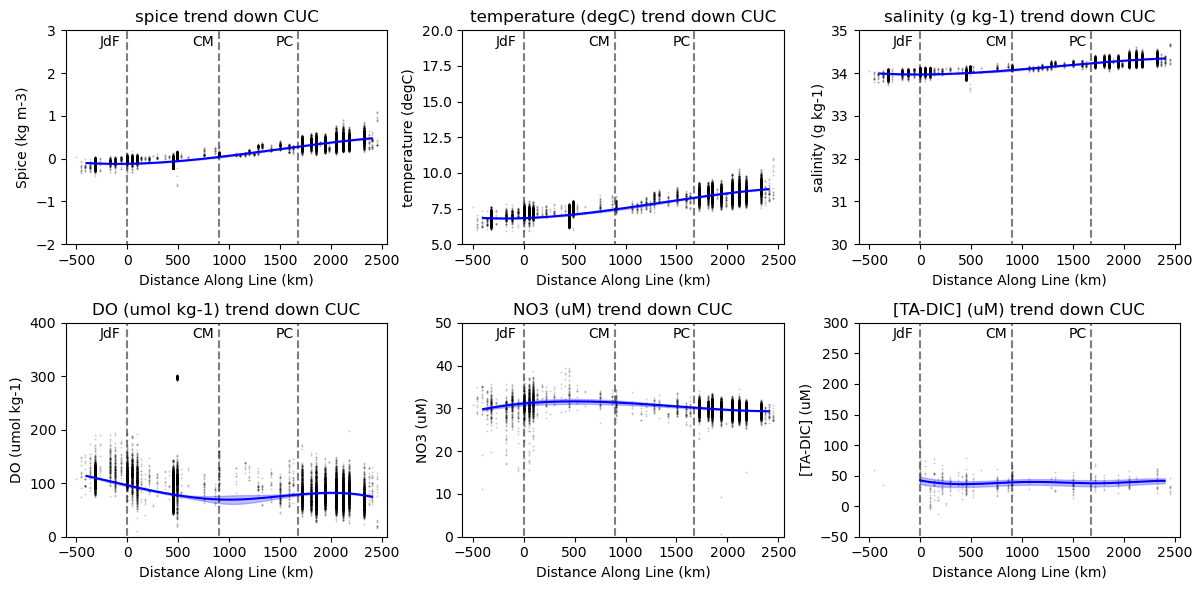

In [8]:
x = obs_cuc['dist']
current = 'CUC'
fig, ax = plt.subplots(2,3, figsize=(12, 6))

plot_property_NStrend(x, 'spice', current, (0,0))
plot_property_NStrend(x, 'temperature (degC)', current, (0,1))
plot_property_NStrend(x, 'salinity (g kg-1)', current, (0,2))
plot_property_NStrend(x, 'DO (umol kg-1)', current, (1,0))
plot_property_NStrend(x, 'NO3 (uM)', current, (1,1))
plot_property_NStrend(x, '[TA-DIC] (uM)', current, (1,2))

plt.tight_layout()

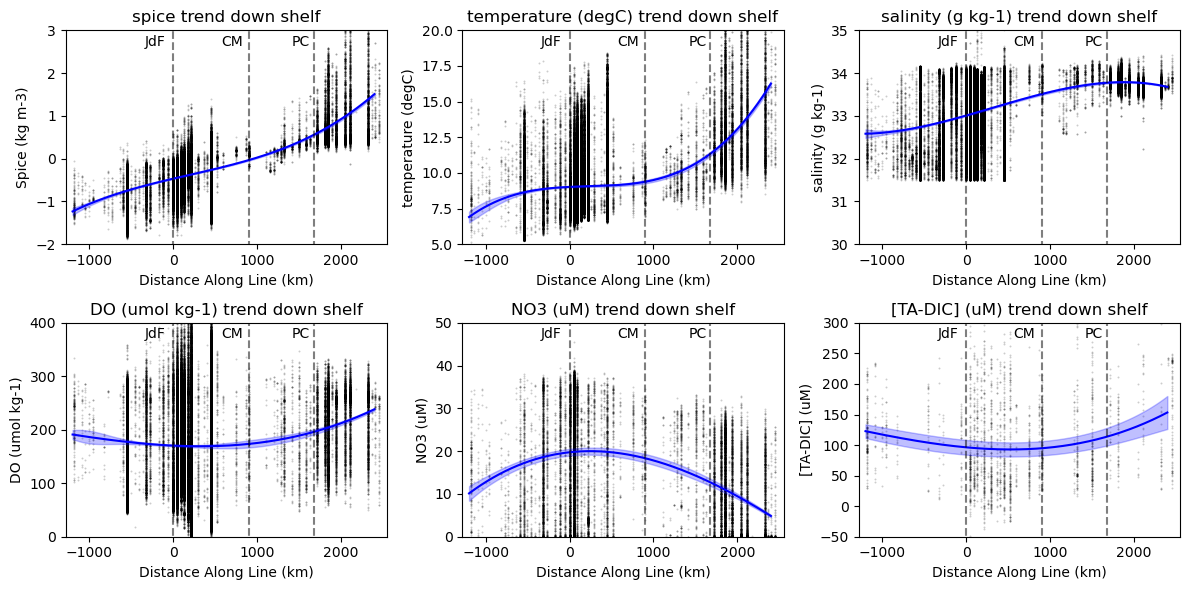

In [9]:
x = obs_shelf['dist']
current = 'shelf'
fig, ax = plt.subplots(2,3, figsize=(12, 6))

plot_property_NStrend(x, 'spice', current, (0,0))
plot_property_NStrend(x, 'temperature (degC)', current, (0,1))
plot_property_NStrend(x, 'salinity (g kg-1)', current, (0,2))
plot_property_NStrend(x, 'DO (umol kg-1)', current, (1,0))
plot_property_NStrend(x, 'NO3 (uM)', current, (1,1))
plot_property_NStrend(x, '[TA-DIC] (uM)', current, (1,2))

plt.tight_layout()

## Box and Whisker Plots

In [10]:
# from checkley and barth 2009 - "define the northern, central, and southern CCS, 
# with divisions at Cape Mendocino and Point Conception, respectively"
# Cape Mendocino = 40.44 N
# Point conception = 35.45 N

obs_northCCS = obs[obs['latitude (degrees_north)'] > 40.44]
obs_centerCCS = obs[(obs['latitude (degrees_north)'] <= 40.44) & (obs['latitude (degrees_north)'] > 35.45)]
obs_southCCS = obs[obs['latitude (degrees_north)'] <= 35.45]

In [11]:
def plot_property_boxwhisker(var_string, current_string, subplot_pos):
    """
    Plot Property Trends up and down the north-south line with origin at bifurcation of California Current
    
    Parameters
    ----------
    var_string : string
        string like 'temperature (degC)' to select property
    current_string : string
        string for one of three currents - either 'CC', 'CUC, 'Shelf'
    subplot_pos : int or tuple
        subplot position
    
    Returns
    -------
    None
        just plots figure
    """
    obs_northCCS_current = obs_northCCS[obs_northCCS.current == current_string]
    obs_centerCCS_current = obs_centerCCS[obs_centerCCS.current == current_string] 
    obs_southCCS_current = obs_southCCS[obs_southCCS.current == current_string] 
    data = [obs_northCCS_current[var_string].dropna(), obs_centerCCS_current[var_string].dropna(), obs_southCCS_current[var_string].dropna()]
    labels = ['Northern', 'Central', 'Southern']
    
    # Plot boxplot
    ax[subplot_pos].boxplot(data, 
                            patch_artist=True, 
                            flierprops=dict(markerfacecolor='k', marker='o', markersize=2, alpha=0.5), 
                            medianprops=dict(color='k', linewidth=2), 
                            boxprops=dict(facecolor='lightblue'))
    ax[subplot_pos].set_xticklabels(labels)
    
    # Plot mean points
    means = [d.mean() for d in data]
    ax[subplot_pos].scatter([1, 2, 3], means, color='red', marker='D', label='Regional Means', s=10, alpha=0.7, zorder=6)
    
    ax[subplot_pos].set_xlabel('CCS Regions')
    if var_string == 'spice':
        ax[subplot_pos].set_ylabel('Spice (kg m-3)')
    else:
        ax[subplot_pos].set_ylabel(var_string)
    
    ax[subplot_pos].set_title(f'{var_string} across the {current_string}')
    ax[subplot_pos].legend()
    return None

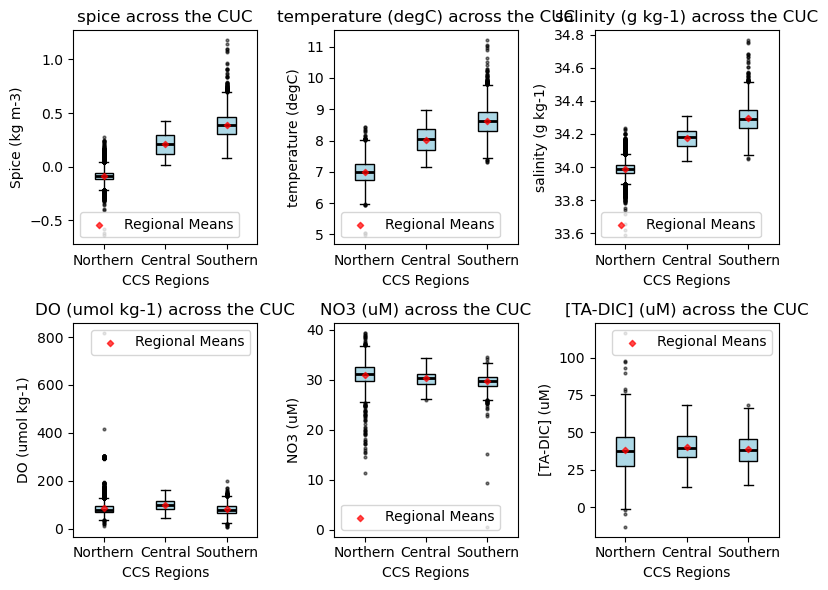

In [12]:
current = 'CUC'
fig, ax = plt.subplots(2,3, figsize=(8, 6))
plot_property_boxwhisker('spice', current, (0,0))
plot_property_boxwhisker('temperature (degC)', current, (0,1))
plot_property_boxwhisker('salinity (g kg-1)', current, (0,2))
plot_property_boxwhisker('DO (umol kg-1)', current, (1,0))
plot_property_boxwhisker('NO3 (uM)', current, (1,1))
plot_property_boxwhisker('[TA-DIC] (uM)', current, (1,2))
plt.tight_layout()

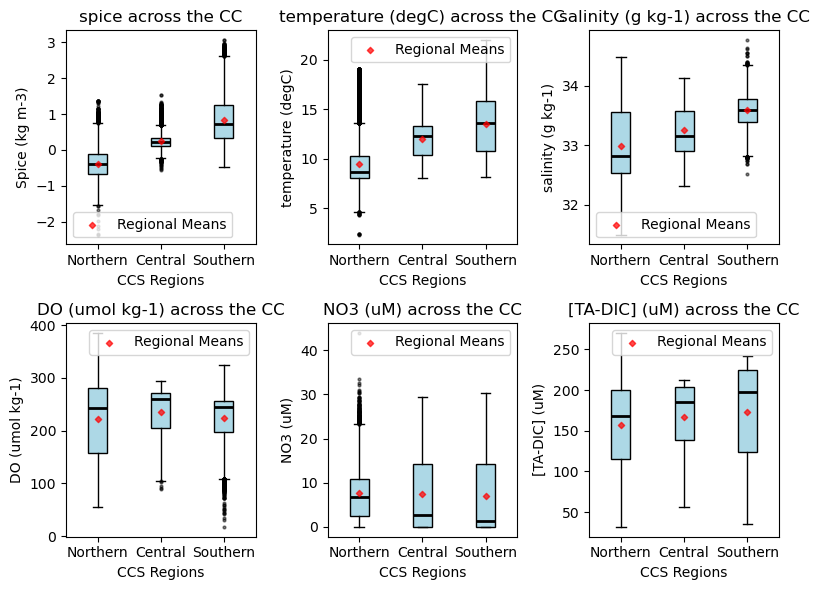

In [13]:
current = 'CC'
fig, ax = plt.subplots(2,3, figsize=(8, 6))
plot_property_boxwhisker('spice', current, (0,0))
plot_property_boxwhisker('temperature (degC)', current, (0,1))
plot_property_boxwhisker('salinity (g kg-1)', current, (0,2))
plot_property_boxwhisker('DO (umol kg-1)', current, (1,0))
plot_property_boxwhisker('NO3 (uM)', current, (1,1))
plot_property_boxwhisker('[TA-DIC] (uM)', current, (1,2))
plt.tight_layout()

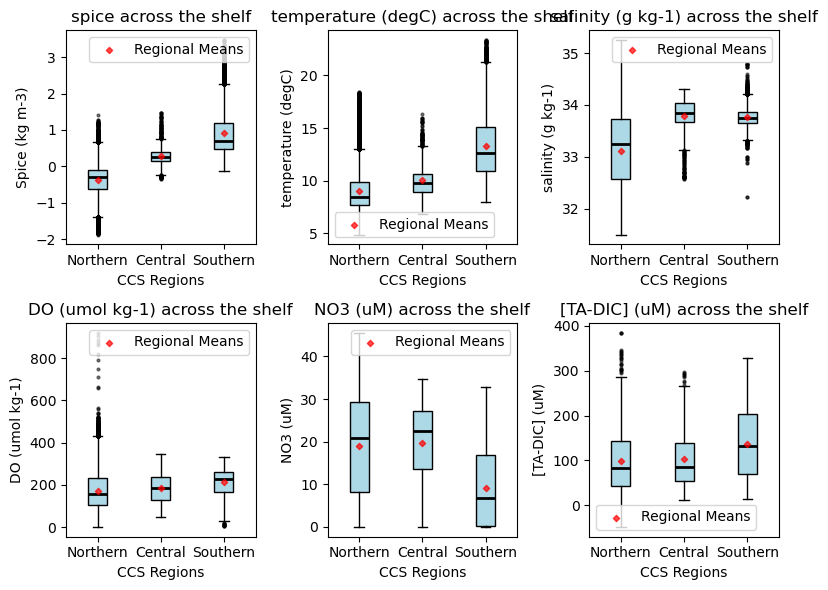

In [14]:
current = 'shelf'
fig, ax = plt.subplots(2,3, figsize=(8, 6))
plot_property_boxwhisker('spice', current, (0,0))
plot_property_boxwhisker('temperature (degC)', current, (0,1))
plot_property_boxwhisker('salinity (g kg-1)', current, (0,2))
plot_property_boxwhisker('DO (umol kg-1)', current, (1,0))
plot_property_boxwhisker('NO3 (uM)', current, (1,1))
plot_property_boxwhisker('[TA-DIC] (uM)', current, (1,2))
plt.tight_layout()